# **Sine function**

## **QML Basics**

Quantum Machine Learning (QML) is a subfield of quantum computing that
focuses on applying quantum principles to machine learning problems.
In QML, we use quantum circuits to perform operations on classical
data, which allows us to take advantage of the parallelism and
superposition inherent in quantum systems.



### **The Sine Function**

In this exercise, we aim to implement a sine function using quantum
machine learning. The sine function is a mathematical function that maps an
input value to a range of values between -1 and 1.

One way to think about the sine function is as a rotation in the
complex plane. When we rotate a point around the origin by an angle
θ, its coordinates are given by ($cos(\theta)$, $sin(\theta)$). This is similar to
how we can use rotations on qubits to map input values to output
values.

### **Parametrized Rotation of a Qubit**

In this code, we're using parametrized rotations on qubits to
implement the sine function. Specifically, we're using the `RX` gate (a
rotation around the x-axis by an angle $\alpha$) and the `RX` gate with a
negative angle ($-\alpha$) these angles will be in the end our optimized 
parameters.

The idea is that if we apply these gates in sequence, we'll get 
rotations that are equivalent to the sine function and the expectation value
will be exactly the value of our implemented function.

In [191]:
# Import necessary libraries for quantum computing and data analysis
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt  # For plotting results later on

# Define hyperparameters for multiple devices
num_shots_list = [20, 50, 100, 300]  # Number of shots (samples) to run the quantum circuit with
num_qubits_list = [5, 4, 3, 2]       # Number of qubits to use in each device
num_params_list = [4, 3, 2, 1]       # Number of parameters per qubit

# Set number of training and testing samples, as well as the number of epochs for optimization
train_samples = 20                   # Number of data points to train with
test_samples = 15                    # Number of data points to test with
num_epochs = 100                     # Number of iterations to run during optimization

# Initialize random seed for reproducibility
np.random.seed(1024)

# Generate training and testing data (sine function values)
X = np.linspace(0, 2*np.pi, train_samples)   # Training input values
Y = np.sin(X)                                # Corresponding sine output values
X_test = np.linspace(0.1, 2*np.pi + 0.1, test_samples)  # Testing input values
Y_test = np.sin(X_test)                      # Corresponding sine output values

# Create multiple devices with different configurations
devices = [qml.device('default.qubit', wires=num_qubits,
shots=num_shots) for num_qubits, num_shots in zip(num_qubits_list,
num_shots_list)]

# Define loss function to calculate total loss from predictions and outputs
def loss_func(predictions):
    """
    Calculate the total loss by summing up squared differences between predictions and actual outputs,
    divided by the number of qubits.

    Args:
        predictions (list): List of predicted values for each output

    Returns:
        float: Total loss value
    """
    # Initializing total loss
    total_loss = 0.0

    # Iterating over each output and prediction, calculating squared difference between them
    for i in range(len(Y)):
        output = Y[i]                                       # Actual output value
        for pred in predictions[i]:                         # Predicted values for this output
            total_loss += (pred - output)**2 / num_qubits   # Calculate mean squared difference

    # Return total loss as a numpy array
    return np.array(total_loss, requires_grad=True)

# Define cost function to calculate cost from parameters and input data
def cost_fn(params):
    """
    Calculate the cost by generating predictions using quantum circuit with given parameters,
    then calling loss function on these predictions.

    Args:
        params (list): List of parameter values for the quantum circuit

    Returns:
        float: Cost value
    """
    # Generate predictions using quantum circuit with provided parameters
    predictions = np.array([quantum_circuit(x, params)  for x in X], requires_grad=True)

    # Calculate cost by calling loss function on these predictions
    cost = loss_func(predictions)

    # Return the cost as a numpy array
    return cost



## **Increasing the number of qubits and parameters**

In this code, we're trying to increase the number of qubits and
parameters in order to reduce the number of shots needed to achieve
good performance. This is because the sine function has a high degree
of symmetry, which means that it can be approximated well using fewer
shots if we use more qubits and parameters.

By increasing the number of qubits and parameters, we're effectively
creating a "larger" quantum circuit that's better able to capture the
nuances of the sine function. This allows us to reduce the number of
shots needed to achieve good performance, which is what we want!

Step = 0 Cost = 31.542153773839125
Step = 10 Cost = 6.953877141655705
Step = 20 Cost = 2.7935432145830013
Step = 30 Cost = 1.1893232545596097
Step = 40 Cost = 0.9213308251960963
Step = 50 Cost = 0.6403892205789338
Step = 60 Cost = 0.5061816314898387
Step = 70 Cost = 0.5713080936986946
Step = 80 Cost = 0.651604506194611
Step = 90 Cost = 0.5778102878684455
Step = 0 Cost = 36.55015532174835
Step = 10 Cost = 16.177327168866178
Step = 20 Cost = 0.9965028535392475
Step = 30 Cost = 2.5949556565089513
Step = 40 Cost = 0.6939228703839603
Step = 50 Cost = 0.6063980732888483
Step = 60 Cost = 0.651887552708093
Step = 70 Cost = 0.5448761488789745
Step = 80 Cost = 0.4764842372077944
Step = 90 Cost = 0.6757973761089201
Step = 0 Cost = 30.322163005718004
Step = 10 Cost = 15.743568035616628
Step = 20 Cost = 4.874665273322126
Step = 30 Cost = 1.4005857369328885
Step = 40 Cost = 1.099444220347831
Step = 50 Cost = 0.5344703886107757
Step = 60 Cost = 0.7365626310586422
Step = 70 Cost = 0.5139920950381497
S

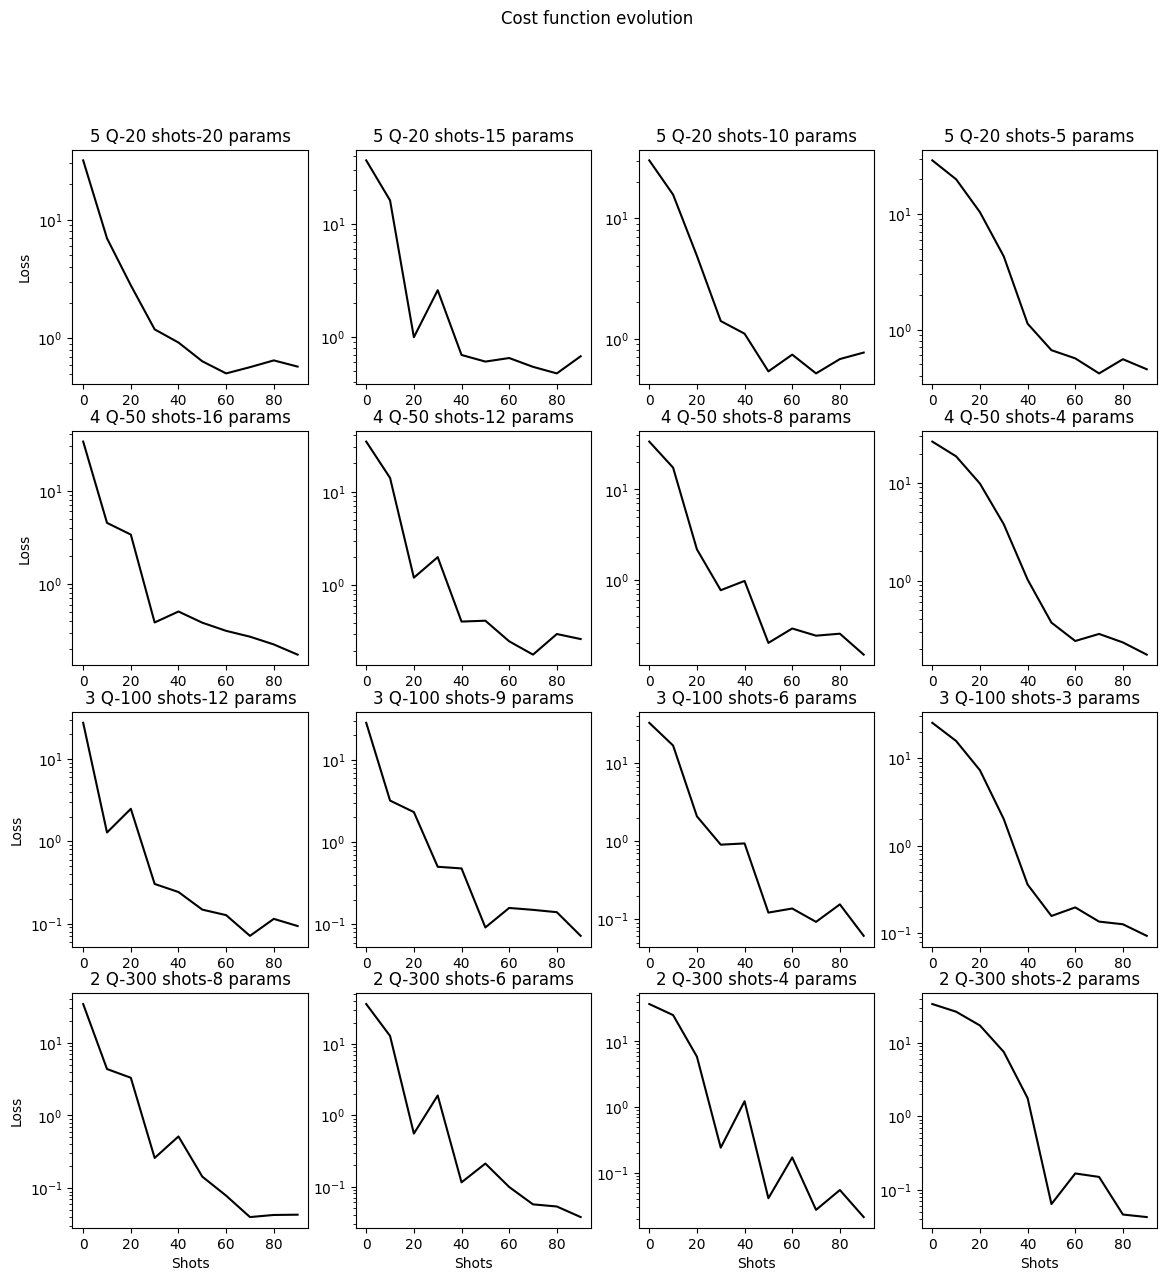

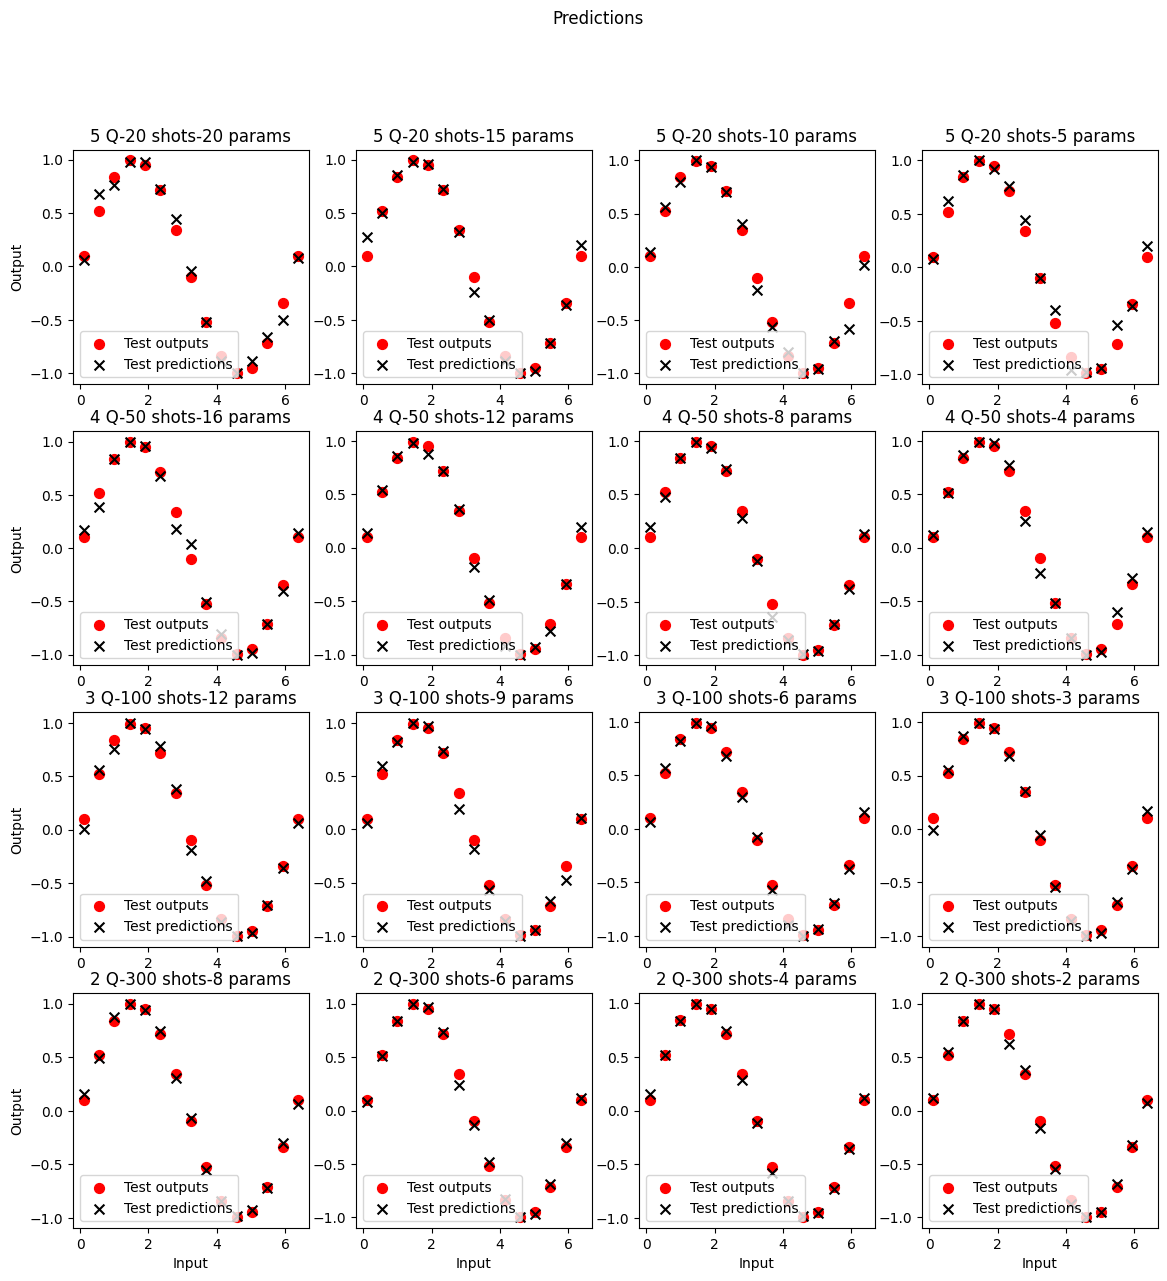

In [192]:
# Create figure for cost function evolution and another for predictions
COST = plt.figure(0, figsize=(14, 14))
TEST_PRED = plt.figure(1, figsize=(14, 14))

# Set up titles for the figures
COST.suptitle('Cost function evolution')
TEST_PRED.suptitle('Predictions')

# Iterate over devices and parameters
for row, dev in enumerate(devices):
    num_qubits = num_qubits_list[row]

    # Iterate over number of parameters for each device
    for col, num_params in enumerate(num_params_list):

        # Initialize optimizer with a step size of 0.05
        opt = qml.AdamOptimizer(stepsize=0.05)

        # Generate random parameters for the quantum circuit
        params = np.random.random((num_qubits, num_params), requires_grad=True)

        # Define quantum circuit as a QNode using the current device
        @qml.qnode(dev)
        def quantum_circuit(x, params):
            """
            Quantum circuit that applies RX gates to qubits with inputs x and parameters params

            Args:
                x (float): Input value for the quantum circuit
                params (numpy.array): Array of parameter values for the RX gates

            Returns:
                list: List of expected values for Pauli Z measurements on each qubit
            """
            for i in range(num_qubits):
                # We apply RX gates to all the qubits with input x
                qml.RX(x, i)

                # We apply RX gate to all the qubits with their specific trainable parameters
                for j in range(num_params):
                    qml.RX(params[i, j], i)

            # Return expected values for Pauli Z measurements on each qubit
            return [qml.expval(qml.PauliZ(wires=i)) for i in range(num_qubits)]

        # Initialize the lists to store cost and step indices
        cost_vector = []
        cost_idx = []

        # Iterating over epochs of optimization
        for i in range(num_epochs):
            params, prev_cost = opt.step_and_cost(cost_fn,params)

            # Saving the cost at every 10th epoch
            if i%10 == 0:
                cost_idx.append(i)
                cost = cost_fn(params)
                cost_vector.append(cost)
                print(f'Step = {i} Cost = {cost}')

        # Generate test predictions by applying quantum circuit to test inputs
        test_predictions = []
        for x_test in X_test:
            prediction = quantum_circuit(x_test,params)
            test_predictions.append(np.mean(prediction))

        # Creating a subplot for the cost function evolution figure
        ax1 = COST.add_subplot(len(num_shots_list), len(num_params_list), row * len(num_params_list) + col + 1)

        # Plotting cost vector on the subplot with log y-scale
        ax1.plot(cost_idx, cost_vector, c='k')
        ax1.title.set_text(f"{num_qubits_list[row]} Q-{num_shots_list[row]} shots-{num_params*num_qubits} params")
        if col == 0:
            ax1.set_ylabel("Loss")
        if row == len(num_shots_list)-1:
            ax1.set_xlabel("Shots")

        # Creating a subplot for the predictions figure
        ax2 = TEST_PRED.add_subplot(len(num_shots_list), len(num_params_list), row * len(num_params_list) + col + 1)

        # Scatter plot of the test outputs
        ax2.scatter(X_test, Y_test, s=50, c='r', marker="o", label='Test outputs')

        # Scatter plot of test predictions
        ax2.scatter(X_test, test_predictions, s=50, c='k', marker="x", label='Test predictions')
        ax2.title.set_text(f"{num_qubits_list[row]} Q-{num_shots_list[row]} shots-{num_params*num_qubits} params")
        plt.legend(loc='lower left')
        if col == 0:
            ax2.set_ylabel("Output")
        if row == len(num_shots_list)-1:
            ax2.set_xlabel("Input")

## **Results**

The results show that by using more qubits and parameters, we can
indeed reduce the number of shots needed to achieve good performance
on the sine function. However, there are still some errors present in
the output, even with a large number of qubits and parameters.

This suggests that while increasing the size of the quantum circuit
can help improve performance, it's not always possible to eliminate
all errors using this approach.

Overall, this code demonstrates some of the key concepts in Quantum 
Machine Learning and shows how they can be applied to implement a sine 
function using quantum circuits. The results highlight the trade-off 
between the number of shots and the number of qubits and parameters 
needed in order to achieve similar performance. While the difference
in time and energy resources is not significant in the simulation, 
reducing the number of shots needed for this circuit to create the 
same output can benefit the real-hardware users. 